## Path sampling: Brownian motion prior, brownian bridge posterior


In this example, we condition a Brownian motion with diffusion coefficient $\sqrt{2}$, starting at $x(0)=-2$, so it hits $+2$ at $T=1$, i.e., $x(1)=+2$. This is a prior -> posterior transport.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
import sys 
sys.path.append('../src/')
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(500)

from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy

from functools import partial
from path_sampling import dfdt, div_f, update_non_amortized
from path_sampling import make_double_well_potential, sample_sde


## We implement our NN annealing approach Algorithm 1 without SPDE below

[0.         0.03448276 0.06896552 0.10344828 0.13793103 0.17241379
 0.20689655 0.24137931 0.27586207 0.31034483 0.34482759 0.37931034
 0.4137931  0.44827586 0.48275862 0.51724138 0.55172414 0.5862069
 0.62068966 0.65517241 0.68965517 0.72413793 0.75862069 0.79310345
 0.82758621 0.86206897 0.89655172 0.93103448 0.96551724 1.        ]
s:  0.0
Train loss: 1763149348864.0
s:  0.0
Train loss: 1737923756032.0
s:  0.034482758620689655
Train loss: 67181887488.0
s:  0.06896551724137931
Train loss: 322133131264.0
s:  0.10344827586206896
Train loss: 22216314880.0
s:  0.13793103448275862
Train loss: 22401148928.0
s:  0.1724137931034483
Train loss: 5542725632.0
s:  0.20689655172413793
Train loss: 2306345728.0
s:  0.24137931034482757
Train loss: 2299067392.0
s:  0.27586206896551724
Train loss: 1336999168.0
s:  0.3103448275862069
Train loss: 1428677888.0
s:  0.3448275862068966
Train loss: 1471425152.0
s:  0.3793103448275862
Train loss: 1373122560.0
s:  0.41379310344827586
Train loss: 865781760.0
s:  

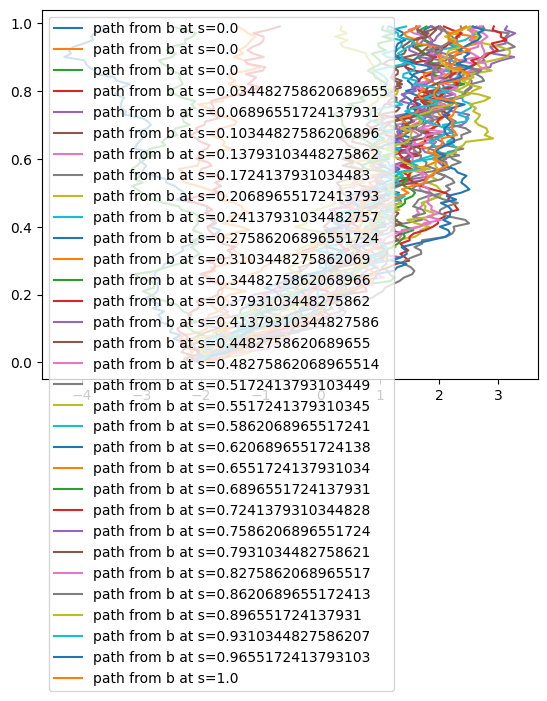

In [21]:
key = jax.random.key(0)
schedule = np.linspace(0,1,30)   # schedule for s
print(schedule)


ndims = 1

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 200, 'batch_size' : 500}


b = lambda x, t: 0.0    # prior drift
A = -2.0
B = 2.0   # endpoint location
A_TH = 0.0

for i, s in enumerate(schedule):

    key = jax.random.fold_in(key, i)
    nn_key, run_key = jax.random.split(key)
    dbds = MLP([3,30,20,10,1], key=nn_key)

    # update b -> b + dbds
    b, A_TH = update_non_amortized(
        V=lambda x: 0.0,   # prior potential, in this case Brownian motion with V(x)=0
        b=b, 
        J=lambda x,y: (1.0/2)*(1/0.01**2)*(x[-2,0]- B)**2,   # sigma = 0.1, condition on second-to-last point = +2
        dbds=dbds,
        hyperparams=hyperparams,
        key=run_key,
        schedule=schedule,
        i=i,
        prior='sde_prior',
        A_TH=A_TH,
        rho = lambda key: jnp.zeros((1,))+A,   #initial point
        refine=False   # default is 30 SPDE steps between every s -> s+\delta_s, with inner stepsize=0.001 for SPDE
    )



## Use the final learned b to generate paths from the target

In [22]:
#from path_sampling import make_b


# use this if we do amortized nn
# b = make_b(schedule[:i], uref, dbds)

key = jax.random.key(3)
path_key, model_key, refine_key = jax.random.split(key, 3)

W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))


# xs : [batch_size, num_steps, ndims]
xs, times = jax.pmap(lambda key:sample_sde(
b=b, 
W = W,
rho =  lambda key: jnp.zeros((ndims,))-2.0,
key=key, 
dt=hyperparams['dt'], 
num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 10))

Text(0, 0.5, 'Time')

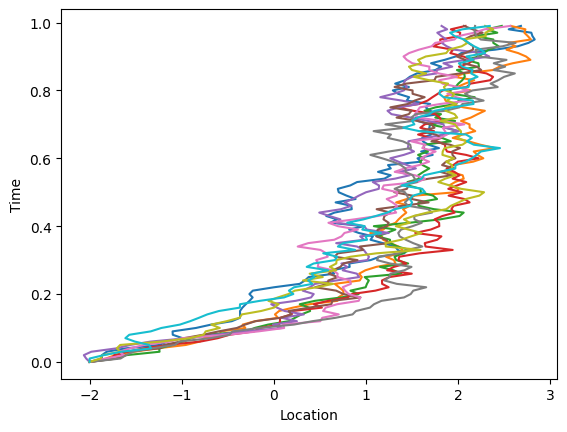

In [24]:
for path in xs:
    plt.plot(path, times[0])

plt.xlabel('Location')
plt.ylabel('Time')


# Compare to exact brownian bridge

We now generate random paths by simulating the Brownian Bridge SDE with a drift term $b=\frac{B-X_t}{T-t}$ and a diffusion term $W=\sqrt{2}dW_t$, where $B=2$ is the target, $T=1$.

Text(0, 0.5, 'Time')

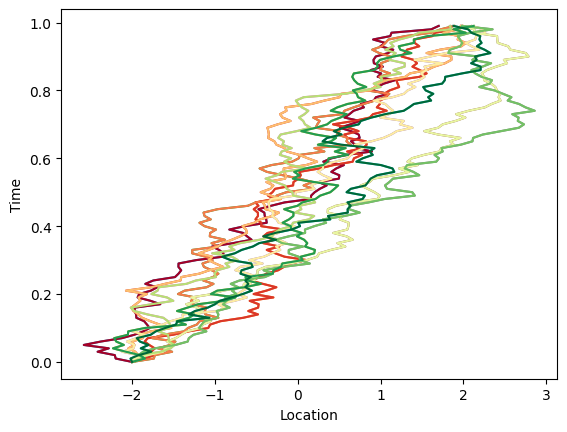

In [ ]:
# estimate marginals
from path_sampling import make_double_well_potential, sample_sde


hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 200}
B = 2.0


paths, times = jax.pmap(lambda k: sample_sde(
    b= lambda x,t: (B - x)/(1-t), 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-2.,   # initial point
    key=k, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(key, 10))

# visualize path
for path, time in zip(paths, times):
    plt.plot(path,time)
    
# plot potential
x = np.linspace(-2.5, 2.5, 100)


cmap = plt.cm.RdYlGn
colors = cmap(np.linspace(0, 1, len(paths)))

# Plot each path with a color from the gradient
for i, (path, time) in enumerate(zip(paths, times)):
    plt.plot(path, time, color=colors[i])
    

plt.xlabel('Location')
plt.ylabel('Time')
